# Brain activation to tactile words in Mandarin
This notebook presents an fMRI analysis of an OpenNeuro dataset. The dataset contains fMRI data obtained from 11 Chinese participants when listening to 672 words in Mandarin Chinese. Each subject participated in 48 runs in total. For computational reasons, only four sessions of the first subject was analyzed.

In [1]:
# Import libraries
import pandas as pd
import nilearn
import nibabel as nib
import numpy as np
import os
from nilearn.plotting import view_img, plot_stat_map

In [2]:
cd

/home/usk


In [3]:
cd Brainhack_project/ds004301

/home/usk/Brainhack_project/ds004301


In [4]:
# Use a functional image for background because anat_img is not preprocessed
from nilearn.image import mean_img
bg_img = mean_img('derivatives/preprocessed_data/sub-01/func/sub-01_task-listening_run-1_bold.nii.gz')

In [5]:
# Read a table which contains every word and its semantic features ranged from 0-7
feature = pd.read_csv('derivatives/annotations/semantic feature/feature.csv')
feature.insert(feature.columns.get_loc('单词')+1, 'word_number', feature.index+1)
feature
# '单词' on the leftmost column means 'word' in Mandarin and this column contains individual stimulus words

,单词,word_number,视觉,明亮度,黑暗度,颜色,图案,大,小,快,...,快乐,悲伤,生气,厌恶,害怕,惊讶,驱动力,需要,注意力,唤醒
0,矮子,1,5.900000,2.500000,2.366667,2.333333,2.233333,2.633333,3.433333,2.500000,...,1.400000,2.600000,1.933333,1.900000,1.433333,1.500000,1.233333,1.233333,2.433333,1.433333
1,爱情,2,3.100000,3.600000,1.466667,2.633333,1.466667,2.033333,2.766667,1.666667,...,5.866667,2.266667,2.300000,1.366667,1.366667,2.700000,4.633333,4.233333,4.333333,5.200000
2,安静,3,3.433333,2.133333,1.833333,2.666667,1.866667,2.033333,3.000000,1.466667,...,3.666667,1.866667,1.400000,1.200000,1.433333,1.366667,1.533333,3.366667,1.933333,1.233333
3,安全,4,3.766667,2.433333,1.566667,2.300000,1.800000,2.533333,2.366667,1.633333,...,4.233333,1.100000,1.133333,1.100000,1.133333,1.333333,2.566667,5.600000,2.200000,1.566667
4,安慰,5,4.600000,2.200000,1.766667,1.866667,1.933333,2.333333,2.900000,1.833333,...,4.233333,2.433333,1.266667,1.333333,1.066667,1.500000,3.533333,3.400000,3.300000,2.733333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,阻塞,668,4.733333,1.300000,3.600000,2.100000,2.900000,2.700000,3.466667,1.566667,...,1.266667,2.933333,3.833333,3.466667,1.966667,1.866667,2.000000,1.266667,3.166667,2.366667
668,罪行,669,3.300000,1.700000,3.866667,2.366667,1.633333,2.433333,2.600000,1.400000,...,1.100000,5.166667,6.000000,5.833333,4.600000,4.733333,2.466667,1.200000,4.500000,4.566667
669,醉,670,5.500000,1.600000,2.733333,3.300000,2.833333,2.300000,3.500000,2.033333,...,1.800000,3.166667,2.933333,3.900000,2.833333,1.933333,1.533333,1.366667,3.900000,3.066667
670,尊贵,671,4.133333,3.066667,1.700000,3.033333,2.133333,3.600000,2.000000,1.600000,...,3.966667,1.133333,1.366667,1.366667,1.300000,1.566667,2.233333,1.966667,4.233333,2.066667


In [6]:
# Define high and low tactile words
# '触摸 (chu mo)' means 'tactile' in Mandarin
# I define tactile words as top 15% since its mean value is extremely low
high_tactile = feature[feature['触摸'] > feature['触摸'].quantile(0.85)][['单词','word_number','触摸']]
low_tactile = feature[feature['触摸'] <= feature['触摸'].quantile(0.85)][['单词','word_number','触摸']]

# Creating a dictionary for tactile words
high_tactile_dict = dict(zip(high_tactile['word_number'].astype(str), ['high_tac']*len(high_tactile)))
low_tactile_dict = dict(zip(low_tactile['word_number'].astype(str),['low_tac']*len(low_tactile)))
tactile_dictionary = {**high_tactile_dict, **low_tactile_dict}

Creating a design maxtrix requires three things: functional data, confounds and events(condition)
Now, I create those using the 'for loop' function for 4 sessions as more than 5 sessions always leads to kernal crash :(

In [7]:
n_run = 4

func_list = [nib.load(f'derivatives/preprocessed_data/sub-01/func/sub-01_task-listening_run-{i+1}_bold.nii.gz') for i in range(n_run)]

confound_list = [
    pd.read_table(f'derivatives/preprocessed_data/sub-01/func/sub-01_task-listening_run-{i+1}_desc-confounds.tsv',
                 usecols = ["trans_x", "trans_y", "trans_z", "rot_x", "rot_y", "rot_z"]) 
    for i in range(n_run)
]
condition = 'tactile'

event_list = []
for i in range(n_run):
    event_pd = pd.read_csv(f'sub-01/func/sub-01_task-listening_run-{i+1}_events.tsv', sep = '\t')
    event_pd['word_number'] = event_pd['stim_file'].str.extract(r'word(\d+)')
    event_pd['tactile'] = event_pd['word_number'].map(tactile_dictionary)
    proc_pd = pd.DataFrame({
        'onset': event_pd['onset'],
        'duration': event_pd['duration'],
        'trial_type': event_pd[condition]
    })
    event_list.append(proc_pd)

In [8]:
from nilearn.glm.first_level import FirstLevelModel

fmri_glm = FirstLevelModel(
    t_r=2,
    noise_model="ar1",
    standardize=False,
    smoothing_fwhm=6,
    hrf_model="spm",
    drift_model="cosine",
    high_pass=0.01,
)


In [9]:
fmri_glm = fmri_glm.fit(func_list, event_list, confound_list)

In [10]:
design_matrix = fmri_glm.design_matrices_[0]

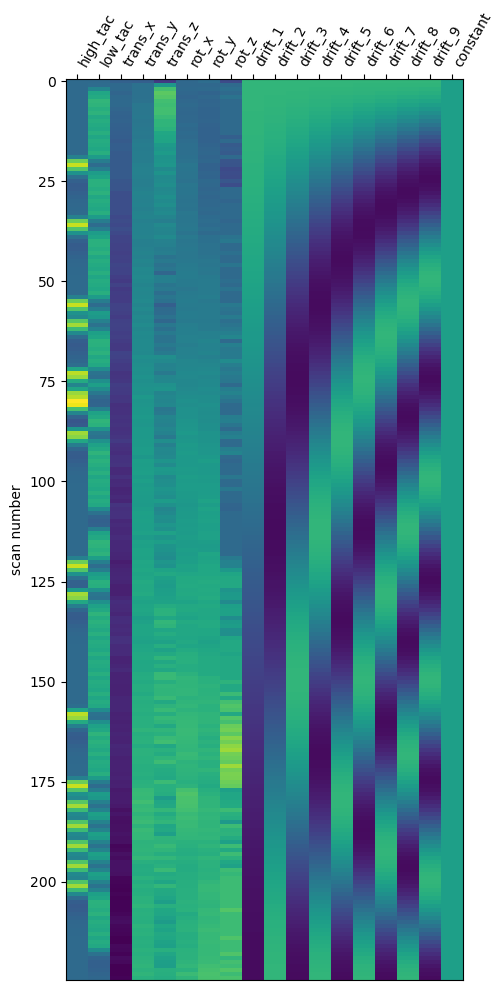

In [11]:
# Plot the design matrix
import matplotlib.pyplot as plt
from nilearn.plotting import plot_design_matrix

plot_design_matrix(design_matrix)

plt.show()

In [12]:
# Create a contrast
cont_vec = np.zeros(design_matrix.shape[1])
cont_vec[0] = 1
cont_vec[1] = -1
print(cont_vec)

[ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


<Axes: label='conditions'>

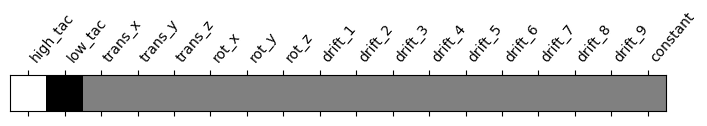

In [13]:
# Plot the contrast
from nilearn.plotting import plot_contrast_matrix

plot_contrast_matrix(cont_vec, design_matrix=design_matrix)

In [14]:
z_map = fmri_glm.compute_contrast(cont_vec, output_type="z_score")

/home/usk/miniconda3/lib/python3.10/site-packages/nilearn/glm/first_level/first_level.py:688: UserWarning: One contrast given, assuming it for all 4 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


/home/usk/miniconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



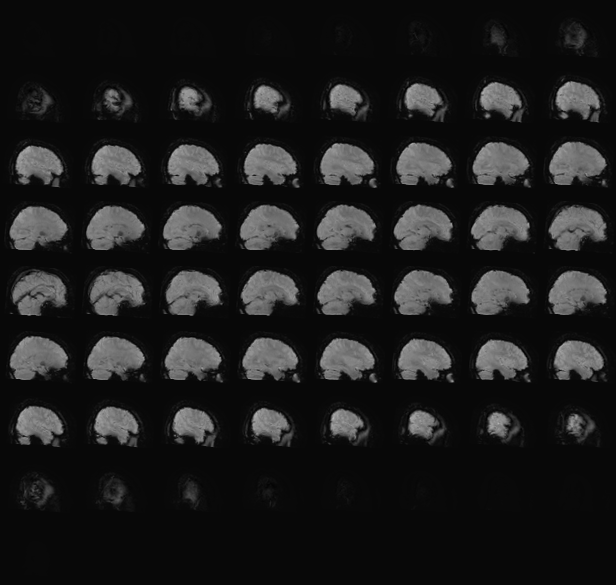
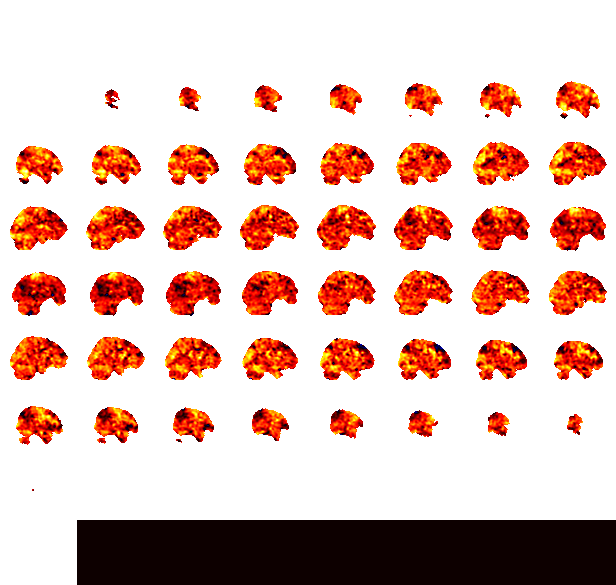

In [15]:
# Plot z-map using the view_img function
from nilearn.plotting import plot_stat_map, view_img
view_img(z_map,bg_img = bg_img, title = f"{condition} - non-{condition} words")

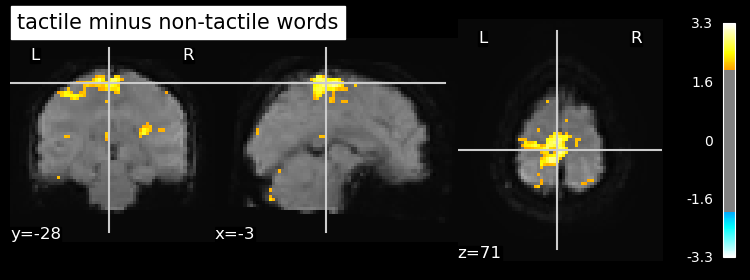

In [16]:
# Now, I use the plot_stat_map function to plot z_map with setting thresholding as 2.0
plot_stat_map(
    z_map,
    bg_img = bg_img,
    threshold=2.0,
    display_mode="ortho",
    black_bg=True,
    title=f"{condition} minus non-{condition} words",
)
plt.show()

Set False positive rate as 0.05%

Uncorrected p<0.005 threshold: 2.807


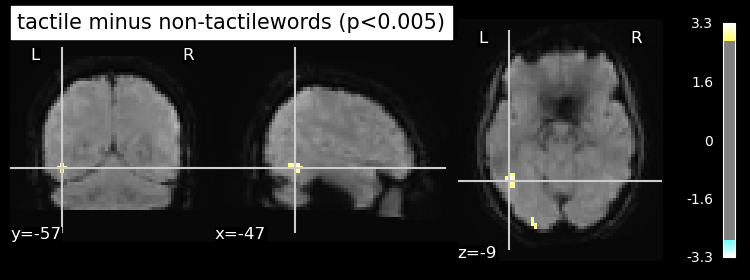

In [17]:
from nilearn.glm import threshold_stats_img

alpha = 0.005
_, threshold = threshold_stats_img(z_map, alpha=alpha, height_control="fpr")
print(f"Uncorrected p<{alpha} threshold: {threshold:.3f}")
plot_stat_map(
    z_map,
    bg_img = bg_img,
    threshold=threshold,
    display_mode="ortho",
    black_bg=True,
    title=f"{condition} minus non-{condition}words (p<{alpha})",
)
plt.show()

Left hemisphere was more activated in general as all the stimuli were speech sound.
Compared to non-tactile words, tactile words activated large areas of parietal lobe as it is where somatosensory cortex is located but also activated visual cortex. It might be due to overlapping features of tactile and visual words.